In [1]:
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

In [2]:
sys.path.insert(0, '../src/')
import zivkovic as z
import coalescentmoments as c
import helpers as h

In [3]:
def fold(n, X):
    '''Fold a site frequency spectrum X with sample size n'''
    i_max = n//2
    k = np.arange(1, n-1)
    multiplicity = 1 + (k == n - k).astype(float)[:i_max]
    if X.ndim == 1:
        folded = (X + X[::-1])[:i_max]
        divisor = multiplicity
    elif X.ndim == 2:
        folded = (X + X[:,::-1] + X[::-1,:] + X[::-1,::-1])[:i_max,:i_max]
        folded[np.diag_indices(i_max)] = 0
        divisor = np.outer(multiplicity, multiplicity)
    return folded / divisor

In [4]:
def get_xi_normed(n, mode, **params):
    '''Calculate the folded SFS (eta) and folded 2-SFS (eta2) normalized by pairwise diversity'''
    if mode == "kingman":
        xi = c.fu_moments(n)[0]
    elif mode in ["exponential", "two-epoch"]:
        xi = z.sigma_i(n, mode, **params)[1:-1]
    elif mode == "beta":
        xi = c.sfs_moments(n, params["alpha"], m2=False)
    return xi / np.sum(xi)


In [5]:
n = 50
cutoff = 15

In [6]:
xi_normed = get_xi_normed(n, 'kingman')
x1_kingman = xi_normed[0]
x2_kingman = np.sum(xi_normed[cutoff:])

In [7]:
t_list = np.logspace(-2, 1, 12)
s_list = np.logspace(-1.2, 0, 12)
x1 = np.zeros((len(t_list), len(s_list)))
x2 = np.zeros((len(t_list), len(s_list)))

for i, t in enumerate(t_list):
    for j, s in enumerate(s_list):
        xi_normed = get_xi_normed(n, 'two-epoch', tau=t, f=s)
        x1[i,j] = xi_normed[0]
        x2[i,j] = np.sum(xi_normed[cutoff:])

../src/zivkovic.py:88: RuntimeWarning: invalid value encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:88: RuntimeWarning: divide by zero encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:88: RuntimeWarning: invalid value encountered in add
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:88: RuntimeWarning: invalid value encountered in subtract
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:144: RuntimeWarning: divide by zero encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:144: RuntimeWarning: invalid value encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:125: RuntimeWarning: divide by zero encountered in true_divide
  scaled_x = lag_x[:,None] / x_scale[None,:]


In [8]:
g_list = np.logspace(-1, 0.5, 5)
x1_exp = np.zeros(len(g_list))
x2_exp = np.zeros(len(g_list))
for i,g in enumerate(g_list):
    xi_normed = get_xi_normed(n, 'exponential', g=g)
    x1_exp[i] = xi_normed[0]
    x2_exp[i] = np.sum(xi_normed[cutoff:])

../src/zivkovic.py:115: RuntimeWarning: invalid value encountered in log
  return np.log(1+x*g)/g


In [9]:
a_list = [1.9, 1.75, 1.5, 1.25]
x1_beta = np.zeros(len(a_list))
x2_beta = np.zeros(len(a_list))
for i,alpha in enumerate(a_list):
    xi_normed = get_xi_normed(n, 'beta', alpha=alpha)
    x1_beta[i] = xi_normed[0]
    x2_beta[i] = np.sum(xi_normed[cutoff:])

In [10]:
# For defining the sizes of figures
single_col_width = 3.5
# Marker edge width
mew = 0.5
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] ='serif'

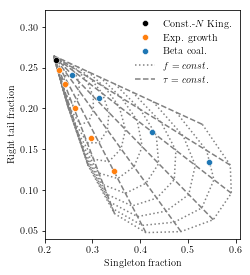

In [11]:
plt.figure(figsize=(single_col_width, 1.2*single_col_width))

plt.plot(x1_kingman, x2_kingman, 'ok', label=r'Const.-$N$ King.', mec='w', mew=mew)
plt.plot(x1_exp, x2_exp, 'o', color='C1', label='Exp. growth', mec='w', mew=mew)
plt.plot(x1_beta, x2_beta, 'o', color='C0', label='Beta coal.', mec='w', mew=mew)


plt.plot(x1, x2, ':', color='0.5', zorder=0, label=r'$f=const.$')
plt.plot(x1.T, x2.T, '--', color='0.5', zorder=0, label=r'$\tau=const.$')

plt.ylim([0.04,0.32])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
# plt.legend()
plt.xlabel('Singleton fraction')
plt.ylabel('Right tail fraction')
plt.savefig('../manuscript/figures/lumped_sfs_comparison.pdf', bbox_inches='tight')